# Background

You've been contracted by Hyundai Heavy Industries to help them build a predictive model for some ships. [Hyundai Heavy Industries](http://www.hyundai.eu/en) is one of the world's largest ship manufacturing companies and builds cruise liners.

You've been flown to their headquarters in Ulsan, South Korea to help them give accurate estimates of how many crew members a ship will require.

They are currently building new ships for some customers and want you to create a model and use it to predict how many crew members the ships will need.

Here is what the data looks like so far:

    Description: Measurements of ship size, capacity, crew, and age for 158 cruise
    ships.


    Variables/Columns
    Ship Name     1-20
    Cruise Line   21-40
    Age (as of 2013)   46-48
    Tonnage (1000s of tons)   50-56
    passengers (100s)   58-64
    Length (100s of feet)  66-72
    Cabins  (100s)   74-80
    Passenger Density   82-88
    Crew  (100s)   90-96
    
It is saved in a csv file called "cruise_ship_info.csv". Your job is to create a regression model that will help predict how many crew members will be needed for future ships. 


First we'll import the libraries we'll need

In [21]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import format_number, col, desc, mean, count
# from pyspark.mllib.stat import Statistics
#from pyspark.ml.stat import Correlation #Not availible in Spark 2.1
from pyspark.ml.feature import VectorAssembler, StringIndexer

import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

Next we start a new Spark session and read in the data which is stores in a CSV fromat on HDFS

In [2]:
spark = spark.builder.appName('Cruiseship').getOrCreate()

In [30]:
cruise_data = spark.read.csv('/user/a208669/cruise_ship_info.csv',inferSchema=True,header=True)

We quickly have a look at the variables and variable types to see whether it was succcesfully imported

In [4]:
cruise_data.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



Next we can have a look at the first few rows of the data 

In [5]:
cruise_data.show()

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|
|    Ecstasy|   Carnival| 22|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Elation|   Carnival| 15|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Fantasy|   Carnival| 23| 

Next we can draw up some summary statistics of the numerical variables

In [7]:
summary_data = cruise_data.describe()

In [24]:
num_col = cruise_data.columns[2:]

In [9]:
summary_data2 = summary_data.select(summary_data['summary'],*(format_number(col(c).cast("float"),2)\
                                                              .alias(c) for c in num_col))

In [10]:
summary_data2.show()

+-------+------+-------+----------+------+------+-----------------+------+
|summary|   Age|Tonnage|passengers|length|cabins|passenger_density|  crew|
+-------+------+-------+----------+------+------+-----------------+------+
|  count|158.00| 158.00|    158.00|158.00|158.00|           158.00|158.00|
|   mean| 15.69|  71.28|     18.46|  8.13|  8.83|            39.90|  7.79|
| stddev|  7.62|  37.23|      9.68|  1.79|  4.47|             8.64|  3.50|
|    min|  4.00|   2.33|      0.66|  2.79|  0.33|            17.70|  0.59|
|    max| 48.00| 220.00|     54.00| 11.82| 27.00|            71.43| 21.00|
+-------+------+-------+----------+------+------+-----------------+------+



From the above summary table we see that there are 158 observations in the dataset and there are no missing values.
This dataset is used purely for illustrative purposes and the methods that are used here can easily  be appied to much bigger datasets. Next we'll have a look at the categorical variable Cruise_line

In [18]:
cruise_data.groupBy('Cruise_line').count().orderBy(desc('count')).show()

+-----------------+-----+
|      Cruise_line|count|
+-----------------+-----+
|  Royal_Caribbean|   23|
|         Carnival|   22|
|         Princess|   17|
| Holland_American|   14|
|        Norwegian|   13|
|            Costa|   11|
|        Celebrity|   10|
|              MSC|    8|
|              P&O|    6|
|             Star|    6|
|Regent_Seven_Seas|    5|
|        Silversea|    4|
|         Seabourn|    3|
|         Windstar|    3|
|           Cunard|    3|
|          Oceania|    3|
|          Crystal|    2|
|           Disney|    2|
|          Azamara|    2|
|           Orient|    1|
+-----------------+-----+



This variable may be usuable. For now we'll only use the numeric variables.  Next we'll draw up some scatter plots of the data. Since there are only 158 observations in this data set we can easily convert this Data frame to a panda Data frame. In the case of billion of records, I woud suggest drawing a random sample of the data for plotting purposes

In [19]:
cruise_data_panda_df = cruise_data.toPandas()

/opt/anaconda2/envs/py345/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


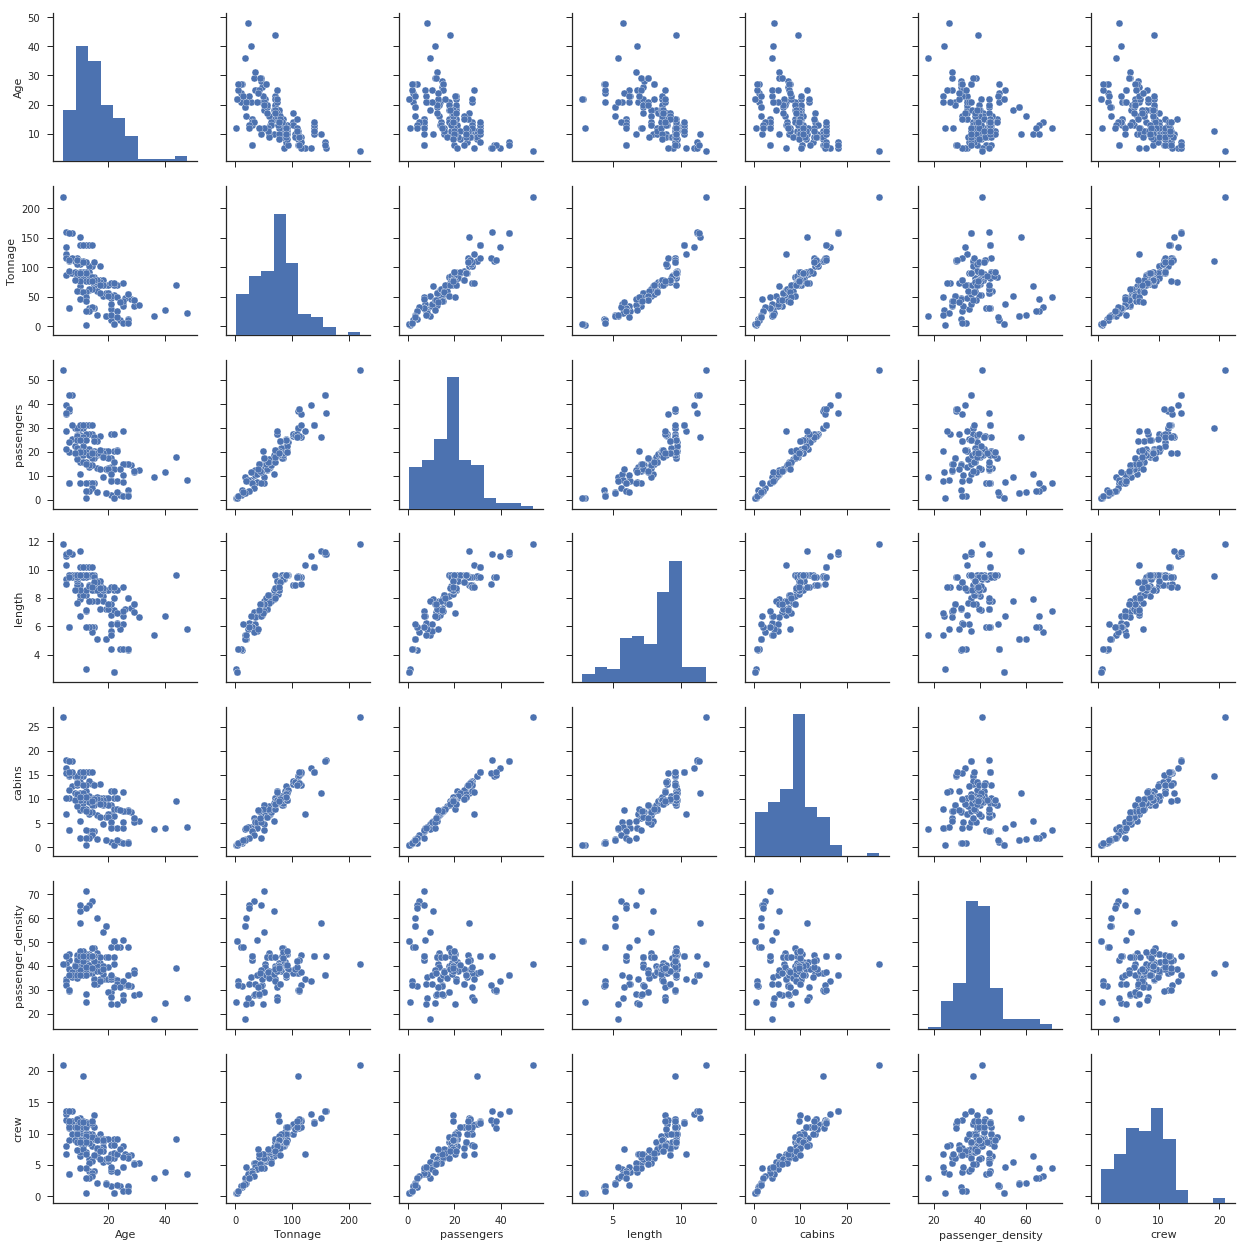

In [21]:
sns.set(style="ticks")
sns.pairplot(cruise_data_panda_df)
sns.plt.show()


/opt/anaconda2/envs/py345/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


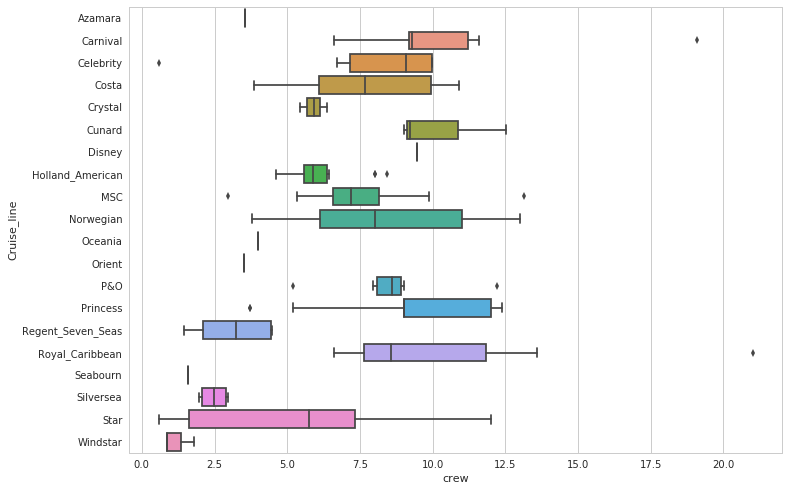

In [75]:
sns.set_style("whitegrid")     

fig, ax = plt.subplots(figsize=(11.7, 8.2))
sns.boxplot(y='Cruise_line',x='crew',data=cruise_data_panda_df,orient='h')
#     bp.set_xticklabels(["No", "Yes"])
plt.show()


From the above plots the following observations can be made:
* The variables are highly correlated - especially Tonnage, length, cabins and passengers. This wil certainly introduce to multicolinearity in the data
* Most of the variables are more or less normally distributed
* There is a strong positive linear relationship between the predictive variable (Crew) and Tonnage, passangers, lenght and cabins. 
* There's a negative relationship between Creq and age. The older the ship, the fewer crew members it has.
* There doesn't seem to be a clear cut relationship between crew and passenger density
* The Cruise line variable is also a nice predictor

We can easily draw up a correlation matrix using Pandas' built in object corr

In [32]:
cruise_data_panda_df.corr()

,Age,Tonnage,passengers,length,cabins,passenger_density,crew
Age,1.000000,-0.606646,-0.515542,-0.532286,-0.510019,-0.278830,-0.530657
Tonnage,-0.606646,1.000000,0.945061,0.922368,0.948764,-0.040846,0.927569
passengers,-0.515542,0.945061,1.000000,0.883535,0.976341,-0.294867,0.915234
length,-0.532286,0.922368,0.883535,1.000000,0.889798,-0.090488,0.895857
cabins,-0.510019,0.948764,0.976341,0.889798,1.000000,-0.253181,0.950823
passenger_density,-0.278830,-0.040846,-0.294867,-0.090488,-0.253181,1.000000,-0.155509
crew,-0.530657,0.927569,0.915234,0.895857,0.950823,-0.155509,1.000000


This can also be  done in Spark

In [55]:
# cruise_data.corr('crew','Age')

def corr_matrix(data, vars):
    corr_list = []
    nvars = len(vars)
    for i in range(nvars):
       for j in range(nvars):
        corr_list.append(data.corr(vars[i],vars[j]))
    ar = np.asarray(corr_list).reshape(nvars,nvars)
    return pd.DataFrame(ar,columns=vars,index=vars)
    
             

In [57]:
corr_matrix(data=cruise_data, vars=num_col)

,Age,Tonnage,passengers,length,cabins,passenger_density,crew
Age,1.000000,-0.606646,-0.515542,-0.532286,-0.510019,-0.278830,-0.530657
Tonnage,-0.606646,1.000000,0.945061,0.922368,0.948764,-0.040846,0.927569
passengers,-0.515542,0.945061,1.000000,0.883535,0.976341,-0.294867,0.915234
length,-0.532286,0.922368,0.883535,1.000000,0.889798,-0.090488,0.895857
cabins,-0.510019,0.948764,0.976341,0.889798,1.000000,-0.253181,0.950823
passenger_density,-0.278830,-0.040846,-0.294867,-0.090488,-0.253181,1.000000,-0.155509
crew,-0.530657,0.927569,0.915234,0.895857,0.950823,-0.155509,1.000000


Next we make use of the VectorAssembler function to put the data in the required format that Spark expects- two columns with the names "label" and "features". The "label" column then needs to have the numerical label, either a regression numerical value, or a numerical value that matches to a classification grouping. The feature column has inside of it a vector of all the features that belong to that row.

In [25]:
x_vars = num_col[:-1] 

In [31]:
assembler = VectorAssembler(inputCols= x_vars,outputCol='features')
model_input_data = assembler.transform(cruise_data)

In [24]:
model_input_data.select('features').show(n=10,truncate=False)

+----------------------------------------------+
|features                                      |
+----------------------------------------------+
|[6.0,30.276999999999997,6.94,5.94,3.55,42.64] |
|[6.0,30.276999999999997,6.94,5.94,3.55,42.64] |
|[26.0,47.262,14.86,7.22,7.43,31.8]            |
|[11.0,110.0,29.74,9.53,14.88,36.99]           |
|[17.0,101.353,26.42,8.92,13.21,38.36]         |
|[22.0,70.367,20.52,8.55,10.2,34.29]           |
|[15.0,70.367,20.52,8.55,10.2,34.29]           |
|[23.0,70.367,20.56,8.55,10.22,34.23]          |
|[19.0,70.367,20.52,8.55,10.2,34.29]           |
|[6.0,110.23899999999999,37.0,9.51,14.87,29.79]|
+----------------------------------------------+
only showing top 10 rows



Next we split the dataset into a training and test dataset. We use a 70/30% training/test split

In [32]:
train_data, test_data = model_input_data.randomSplit([0.7,0.3],seed=738)

Now we can fit the model to the training data!

In [39]:
reg_model = LinearRegression(featuresCol = 'features',labelCol= 'crew').fit(train_data)

Let's have a look at the Model coefficients,standard errors and p-values.

In [30]:
def summary_table(model):
    coef = [x for x in model.coefficients]
    coef = coef + [model.intercept]
    summ = model.summary
    summary_df = pd.DataFrame({'Variable': x_vars + ['Intercept'], 'Coefficient' : coef, 'Std Error': summ.coefficientStandardErrors,
                           't value': summ.tValues,'P value': ['%.4f' % x for x in summ.pValues]},
                          columns=['Variable','Coefficient','Std Error','t value','P value'])
    return summary_df
    
    

In [31]:
summary_table(reg_model)

,Variable,Coefficient,Std Error,t value,P value
0,Age,-0.020013,0.015878,-1.260440,0.2104
1,Tonnage,-0.003843,0.016001,-0.240184,0.8107
2,passengers,-0.176891,0.053510,-3.305752,0.0013
3,length,0.335229,0.137468,2.438607,0.0165
4,cabins,1.025534,0.152196,6.738224,0.0000
5,passenger_density,0.010764,0.018449,0.583431,0.5609
6,Intercept,-0.694485,1.162012,-0.597658,0.5514


The R<sup>2</sup> value and root mean square error is equal to

In [40]:
print('R2: {:1.2f}'.format(reg_model.summary.r2))

R2: 0.94


In [42]:
print('RMSE: {:1.2f}'.format(reg_model.summary.rootMeanSquaredError))

RMSE: 0.91


From the above table we see that 3 of the tables are highly significant:
* Passengers
* Length
* Cabins

The effect of multicolinearity is also obvious by observing that some of the variables that came out as highly predictive in the scatter plots and correlation matrix are suddenly not predictive and the coefficients having the reverse signs than what was observed in the scatter plots. The high R<sup>2</sup> value and low Root Mean square error value is not surprising since there are variables that are highly correlated with the outcome variable

Lastlly we can test our model by fitting it on the test data

In [58]:
test_results = reg_model.evaluate(test_data)


In [65]:
print("RMSE: {:1.2f}".format(test_results.rootMeanSquaredError))
print("MSE: {:1.2f}".format(test_results.meanSquaredError))
print("R2: {:1.2f}".format(test_results.r2))

RMSE: 1.15
MSE: 1.32
R2: 0.86
